<a href="https://colab.research.google.com/github/NMA-Miracle/deeplearning_musicclassification/blob/main/train_model_plus_eval_vanilla1_augment1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music classification and generation with spectrograms

**By Neuromatch Academy**

__Content creators:__ Beatrix Benko, Lina Teichmann

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

## This notebook
This notebook loads the GTZAN dataset which includes audiofiles and spectrograms. You can use this dataset or find your own. The first part of the notebook is all about data visualization and show how to make spectrograms from audiofiles. The second part of the notebook includes a CNN that is trained on the spectrograms to predict music genre. Below we also provide links to tutorials and other resources if you want to try to do some of the harder project ideas. 

Have fun :) 


## Acknowledgements
This notebook was written by Beatrix Benkő and Lina Teichmann.

**Useful code examples:** 

https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

[https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

[https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py)

https://github.com/kamalesh0406/Audio-Classification 

https://github.com/zcaceres/spec_augment

https://musicinformationretrieval.com/ipython_audio.html 

---
# Setup

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
data_drive_path = '/content/drive/MyDrive/NMA/music.zip'
%cd '/content/drive/MyDrive/NMA'

/content/drive/.shortcut-targets-by-id/1WB812V4KRTgPyreWuW0usRMhTeRGD7zG/NMA


In [31]:
# @title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
# !pip install Ipython --upgrade
!pip install -e .
!pip install torchaudio-augmentations
!pip install torch_audiomentations

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/.shortcut-targets-by-id/1WB812V4KRTgPyreWuW0usRMhTeRGD7zG/NMA
  Attempting uninstall: src
    Found existing installation: src 0.0.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# %cd './Data'
# %pwd 

In [33]:
#unzipping

# file_path = '/content/drive/MyDrive/NMA/Data/genres_original.zip'
# from zipfile import ZipFile
# with ZipFile(file_path, 'r') as zipObj:
#   # Extract all the contents of zip file in different directory
#   zipObj.extractall()

In [34]:
%cd ..

/content/drive/.shortcut-targets-by-id/1WB812V4KRTgPyreWuW0usRMhTeRGD7zG


In [35]:
# Import necessary libraries.
# %load_ext autoreload # live update of our functions
# %autoreload 2

#@title Imports
from pathlib import Path
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
import soundfile as sp

import os
import glob
import imageio
import random, shutil
import torch
import torchaudio
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
#import librosa.display
import requests


# from src.z_transform import ZTransformer
# from src.conv_net import ConvolutionalMusicNet, train

import torch
import torchaudio
import torchaudio.functional as Func
import torchaudio.transforms as T

import numpy as np
import soundfile as sf
import torch
from torch.utils import data
import random, shutil
import torchaudio.transforms as T
from torchaudio_augmentations import (
    Compose,
    Delay,
    Gain,
    HighLowPass,
    Noise,
    PitchShift,
    PolarityInversion,
    RandomApply,
    RandomResizedCrop,
    Reverb,
)
np.random.seed(42)

In [36]:
!ls 

NMA


In [37]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

device = set_device()

GPU is enabled in this notebook.


In [38]:
#@title Custom class to split and save the dataset
class Utils:
  def __init__(self, data_dir):
    self.data_dir =  data_dir
    self.folder_names = [f'{data_dir}/train/', f'{data_dir}/test/', f'{data_dir}/val/']

  def split_dataset(self)->None:
    audio_dir = f"{self.data_dir}/genres_original/"
    train_dir = self.folder_names[0]
    test_dir = self.folder_names[1]
    val_dir = self.folder_names[2]

    for f in self.folder_names:
      if os.path.exists(f):
        shutil.rmtree(f)
        os.mkdir(f)
      else:
        os.mkdir(f)

    # Loop over all genres.

    genres = list(os.listdir(audio_dir))
    for g in genres:
      # find all audios & split in train, test, and validation
      src_file_paths= []
      for im in glob.glob(os.path.join(audio_dir, f'{g}',"*.wav"), recursive=True):
        src_file_paths.append(im)
      random.shuffle(src_file_paths)
      test_files = src_file_paths[0:10]
      val_files = src_file_paths[10:20]
      train_files = src_file_paths[20:]

      #  make destination folders for train and test images
      for f in self.folder_names:
        if not os.path.exists(os.path.join(f + f"{g}")):
          os.mkdir(os.path.join(f + f"{g}"))

      # copy training and testing images over
      for f in train_files:
        shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
      for f in test_files:
        shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
      for f in val_files:
        shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))
  
  
  def create_dataset(self,files_dir: str,out_file:str, dur=3)->None:
    """
      @param: files_dir -- str, takes the directory path to the subfolders containing our music genres
      @param: out_file -- str, takes the file path where the created n seconds audio and labels will be stored
      @param: dur -- int, takes the select split duration 

      @return: None
    
    """
    CLASSES =  os.listdir(files_dir)
    dur = dur
    X = [] # n seconds samples audio list
    labels = [] # label indices
    for dir in os.listdir(files_dir):
      sub_dir = Path(files_dir, dir)
      for file in sub_dir.glob("*.wav"):
        if(file.name != 'jazz.00054.wav'):
          y,sr = librosa.load(file, sr=None)
          stepsize = int(sr * dur)
          for idx in range(0, len(y),  stepsize):
            x = y[idx :  idx + stepsize ]
            if(len(x) >=  stepsize):
              X.append(x)
              labels.append(CLASSES.index(dir))
    X =  np.array(X)
    labels = np.array(labels)
    np.savez(file=out_file,X =  X, y = labels,  C = CLASSES)
    print(f"A dataset of musics with {X.shape[0]} samples created successfully")
  
  def load(self, filename):
    if( filename.is_file()):
      data =  np.load(filename, allow_pickle=True)
      X =  data['X'] #n seconds audio samples
      y =  data['y'] #int label indices 
      CLASSES  = data['C'] # List of CLASSES
      return X,y,CLASSES
    else:
      return None,None,None

In [39]:
#We are going to test our class
data_dir = './Data'
utils =  Utils(data_dir)

utils.folder_names

train_dir = Path('/content/drive/MyDrive/NMA/Data/train')
test_dir = Path('/content/drive/MyDrive/NMA/Data/test')
val_dir = Path('/content/drive/MyDrive/NMA/Data/val')

train_file = Path('/content/drive/MyDrive/NMA/Data/train.npz')
test_file = Path('/content/drive/MyDrive/NMA/Data/test.npz')
val_file = Path('/content/drive/MyDrive/NMA/Data/val.npz')

# utils.split_dataset()

In [40]:
# utils.create_dataset(train_dir, out_file=train_file,dur=3)
# utils.create_dataset(test_dir, out_file=test_file,dur=3)
# utils.create_dataset(val_dir, out_file=val_file,dur=3)

In [41]:
test_dir

PosixPath('/content/drive/MyDrive/NMA/Data/test')

In [42]:
# # Loading and test

# X,y,CLASSES = utils.load(train_file)
# X.shape 

In [43]:
# X,y,CLASSES = utils.load(test_file)
# X.shape 

In [44]:
# X,y,CLASSES = utils.load(val_file)
# X.shape 

In [45]:
# ConvolutionalMusicNet()

In [46]:
spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]


In [47]:
#@title Specify dataset class
class MiracleDataset(Dataset):
  def __init__(self, X:np.ndarray,y:np.ndarray,n_fft=1024,hop_length = 512,sr=22050, loader=None,win_length = None,transform=None, target_transform=None):
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length
    self.sr = sr
    self.X =  X
    self.labels =  y 
    self.transform =  transform 
    self.target_transform =  target_transform
    self.loader = loader
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self,idx):
    audio =  torch.from_numpy(self.X[idx])
    # audio.to(device)
    #audio =  self.X[idx].to(device)
    label =  self.labels[idx]
    #label = torch.from_numpy(label)
    #label.to(device)

    if self.transform and self.loader == 'train':
      self.orig_audio = audio
      audio = self.transform(audio)
      #Manual pitchshifting 
      p01 = torch.rand(1)
      p02 = torch.rand(1)
      if p01 <= 0.4:
        audio = PitchShift(sample_rate=self.sr, n_samples=audio.shape[0], pitch_shift_min=4, pitch_shift_max=5)(audio.reshape(1,audio.shape[0]))
        #print(f'Shape after Pitching: {audio.shape}')
      # if p02 <= 0.3:
      #   audio = Reverb(sample_rate=self.sr,reverberance_min=90,reverberance_max=91,room_size_min=90,room_size_max=91,)(audio)
      #   print(f'Shape after Reverbing: {audio.shape}')
    # define transformation
    spectrogram = T.Spectrogram(
        n_fft=self.n_fft,
        win_length=self.win_length,
        hop_length=self.hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
    )

    # Perform transformation
    self.modified_audio = audio
    
    
    spec = spectrogram(audio.squeeze())
    spec_DB = T.AmplitudeToDB()(spec)

    if self.target_transform:
        label = self.target_transform(label)
    return spec_DB.expand((1, spec_DB.shape[0], spec_DB.shape[1])),label
    #return spec_DB,label

In [48]:
#@title Specify Dataloaders
import gc
# Load train dataset
X,y,CLASSES = utils.load(train_file)
print(X.shape, y.shape, CLASSES.shape)
# Train loader
ds =  MiracleDataset(X,y, loader='train',transform= Compose( [
        RandomApply([PolarityInversion()], p=0.8),
        RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
        RandomApply([Gain()], p=0.2),
        RandomApply([HighLowPass(sample_rate=22050)], p=0.8)
    ]) )
trainloader =  DataLoader(ds, batch_size= 64, shuffle=True, num_workers=0) 
del X
del y
gc.collect()
##Load Validation dataset
X,y,CLASSES = utils.load(val_file)

ds =  MiracleDataset(X,y)
validationloader =  DataLoader(ds, batch_size= 64, shuffle=True, num_workers=0) 
del X
del y
gc.collect()
# Load Test dataset
X,y,CLASSES = utils.load(test_file)

ds =  MiracleDataset(X,y)
testloader =  DataLoader(ds, batch_size= 64, shuffle=True, num_workers=0)
del X
del y
gc.collect()

(7993, 66150) (7993,) (10,)


24

In [49]:
#@title Test Validation and test loaders

# samples,labels = next(iter(trainloader)) 
# print(samples.shape)

#samples,labels = next(iter(testloader)) 
#print(samples.shape)

# samples,labels = next(iter(validationloader)) 
# print(samples.shape)

## Train a simple CNN 

In [53]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=3584, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

      if epoch%10 == 0:
        model_dir = "/content/drive/MyDrive/NMA/models"
        Path(model_dir).mkdir(parents=True, exist_ok=True)
        name = 'model' + str(epoch) + 'ep.pt'

        torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss,
                    }, Path(model_dir, name))

  return train_loss, train_acc, validation_loss, validation_acc

In [51]:
!nvidia-smi
print(device)

Wed Jul 27 07:36:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |   2788MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
# from IPython.display import Audio

# sample_path = '/content/drive/MyDrive/NMA/Data/train/reggae/reggae.00001.wav'
# audio, sr = torchaudio.load(sample_path)

In [ ]:
# %time
# %prun

# spectrogram = T.Spectrogram(
#     n_fft=1024,
#     win_length=None,
#     hop_length=512,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
# )

# spec = spectrogram(audio)  
# spec_DB = T.AmplitudeToDB()(spec)

In [56]:
%time
%prun


transform= Compose( [
        RandomApply([PolarityInversion()], p=0.8),
        RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
        RandomApply([Gain()], p=0.2),
        RandomApply([HighLowPass(sample_rate=22050)], p=0.8)
    ])

audio = transform(audio)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
 

In [57]:
%time
%prun

audio = PitchShift(sample_rate=sr, n_samples=audio.shape[0], pitch_shift_min=4, pitch_shift_max=5)(audio)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
 

In [59]:
# Run training.
%prun
net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, trainloader, validationloader, 50)

  0%|          | 0/20 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


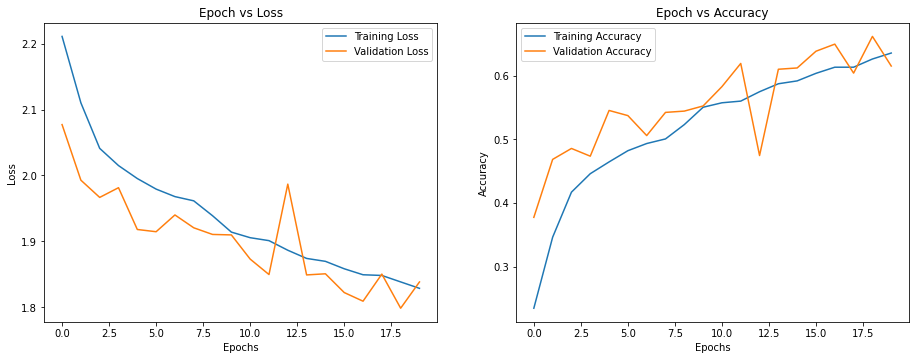

In [62]:
train_loss
_train_loss, _train_acc, _validation_loss, _validation_acc = [], [], [], []
for loss, acc, val_loss, val_acc in zip(train_loss, train_acc, validation_loss, validation_acc):
  _train_loss.append(loss.to("cpu").detach().numpy())
  _train_acc.append(acc)
  _validation_loss.append(val_loss)
  _validation_acc.append(val_acc)
plot_loss_accuracy(_train_loss, _train_acc, _validation_loss, _validation_acc)

import pandas as pd

df = pd.DataFrame({'val_loss': _validation_loss, 'train_loss': _train_loss , 'train_acc': _train_acc, 'val_acc': _validation_acc})
df.to_csv('/content/drive/MyDrive/NMA/Stats/output_vanilla1_augment1.csv')



### Saving and Loading models

In [63]:
# Saving
model_dir = "/content/drive/MyDrive/NMA/models"
Path(model_dir).mkdir(parents=True, exist_ok=True)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
torch.save({
            'epoch': 20,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, Path(model_dir, "model_augmented_20_vanilla1_augment1.pt"))


In [64]:
@torch.no_grad()

def get_all_preds(model, loader, device):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, labels)
             ,dim=0)
        
    return all_preds, all_labels

In [65]:
#Loading
model_dir = "/content/drive/MyDrive/NMA/models"

net = music_net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

checkpoint = torch.load(Path(model_dir, "model_augmented_20.pt"))
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

prob_class, true_labels = get_all_preds(net, testloader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [66]:
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd
print(prob_class.shape)
pred_class = torch.argmax(prob_class, dim=1)
print(pred_class.shape)

print(true_labels.shape)

conf_mat = metrics.confusion_matrix(true_labels.to('cpu').detach().numpy(), pred_class.to('cpu').detach().numpy())

torch.Size([1000, 10])
torch.Size([1000])
torch.Size([1000])


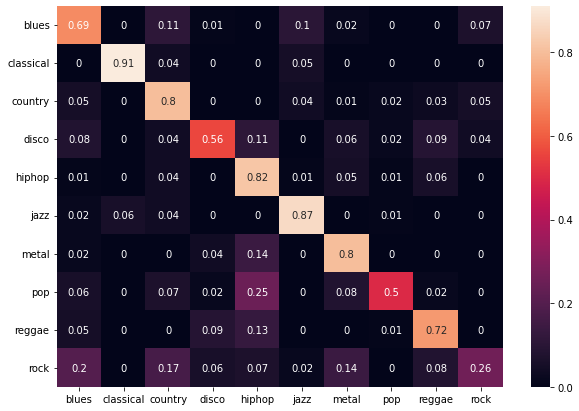

In [67]:
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)
df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in CLASSES],
                  columns = [i for i in CLASSES])
plt.figure(figsize = (10,7))

CNF = sns.heatmap(df_cm, annot=True)
fig = CNF.get_figure()
fig.savefig("/content/drive/MyDrive/NMA/figures/CNF.png") 

In [68]:
report = metrics.classification_report(true_labels.to('cpu').detach().numpy(), pred_class.to('cpu').detach().numpy(),target_names=CLASSES)
print(report)

              precision    recall  f1-score   support

       blues       0.58      0.69      0.63       100
   classical       0.94      0.91      0.92       100
     country       0.61      0.80      0.69       100
       disco       0.72      0.56      0.63       100
      hiphop       0.54      0.82      0.65       100
        jazz       0.80      0.87      0.83       100
       metal       0.69      0.80      0.74       100
         pop       0.88      0.50      0.64       100
      reggae       0.72      0.72      0.72       100
        rock       0.62      0.26      0.37       100

    accuracy                           0.69      1000
   macro avg       0.71      0.69      0.68      1000
weighted avg       0.71      0.69      0.68      1000



In [69]:
# Hook the feature maps
print(net)

music_net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3584, out_features=10, bias=True)
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [70]:
from torchsummary import summary

summary(net, (1, 513, 130))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 511, 128]              80
       BatchNorm2d-2          [-1, 8, 511, 128]              16
            Conv2d-3          [-1, 16, 253, 62]           1,168
       BatchNorm2d-4          [-1, 16, 253, 62]              32
            Conv2d-5          [-1, 32, 124, 29]           4,640
       BatchNorm2d-6          [-1, 32, 124, 29]              64
            Conv2d-7           [-1, 64, 60, 12]          18,496
       BatchNorm2d-8           [-1, 64, 60, 12]             128
            Conv2d-9           [-1, 128, 28, 4]          73,856
      BatchNorm2d-10           [-1, 128, 28, 4]             256
          Dropout-11                 [-1, 3584]               0
           Linear-12                   [-1, 10]          35,850
Total params: 134,586
Trainable params: 134,586
Non-trainable params: 0
-------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [71]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION
# Idea: https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html
# placeholder for batch features
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [72]:
##### REGISTER HOOK

net.fc1.register_forward_hook(get_features('feats'))

In [73]:
##### FEATURE EXTRACTION LOOP

# placeholders
PREDS = []
FEATS = []
LABELS = []


# loop through batches
for idx, batch in enumerate(testloader):
    net.eval()
    # move to device
    images, labels = batch
    images = images.to(device)
       
    # forward pass [with feature extraction]
    preds = net(images)
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())
    LABELS.append(labels.cpu().numpy())
    # # early stop
    # if idx == 9:
    #     break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [74]:
##### INSPECT FEATURES

PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
LABELS = np.concatenate(LABELS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)
print('- labels shape:', LABELS.shape)

- preds shape: (1000, 10)
- feats shape: (1000, 10)
- labels shape: (1000,)


In [75]:
feats_reshaped = FEATS.reshape(FEATS.shape[0], -1)
feats_reshaped.shape


(1000, 10)

In [76]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(feats_reshaped)

# sns.scatterplot(feat_data)

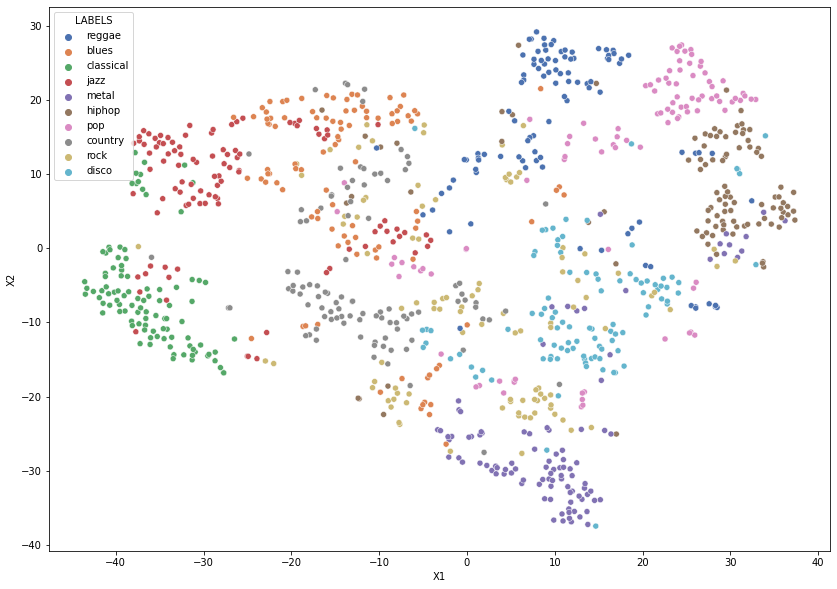

In [77]:
from matplotlib.pyplot import figure
figure(figsize=(14, 10))

new_labels = [CLASSES[i] for i in LABELS]

feat_dict= {'X1': X_embedded[:, 0], 'X2': X_embedded[:, 1], 'LABELS': new_labels}

feat_data = pd.DataFrame(data=feat_dict)

scatterplot = sns.scatterplot(data=feat_data, x="X1", y="X2", hue="LABELS", palette="deep")
fig = scatterplot.get_figure()
fig.savefig("/content/drive/MyDrive/NMA/figures/Scatterplot02.png") 

In [78]:
# !pip install timm
# import timm
# import sklearn.metrics as metrics
# import seaborn as sns
# import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.6 MB/s 


In [79]:
# # Loading


# model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
# model_dir = "/content/drive/MyDrive/NMA/models/transformer"

# checkpoint = torch.load(Path(model_dir, "Fine_tune_spectrograms_21.params"))
# model.load_state_dict(checkpoint['model_state_dict'])


FileNotFoundError: ignored

In [ ]:
# # print(model)
# model.to(device)

In [ ]:
# #@title Specify dataset class
# class MiracleDatasetForTransformer(Dataset):
#   def __init__(self, X:np.ndarray,y:np.ndarray,n_fft=1024,hop_length = 512,sr=22050, loader=None,win_length = None,transform=None, target_transform=None):
#     self.n_fft = n_fft
#     self.win_length = win_length
#     self.hop_length = hop_length
#     self.sr = sr
#     self.X =  X
#     self.labels =  y 
#     self.transform =  transform 
#     self.target_transform =  target_transform
#     self.loader = loader
  
#   def __len__(self):
#     return self.X.shape[0]
  
#   def __getitem__(self,idx):
#     audio =  torch.from_numpy(self.X[idx])
#     # audio.to(device)
#     #audio =  self.X[idx].to(device)
#     label =  self.labels[idx]
#     #label = torch.from_numpy(label)
#     #label.to(device)

#     if self.transform and self.loader == 'train':
#       self.orig_audio = audio
#       audio = self.transform(audio)
#       #Manual pitchshifting 
#       p01 = torch.rand(1)
#       p02 = torch.rand(1)
#       if p01 <= 0.4:
#         audio = PitchShift(sample_rate=self.sr, n_samples=audio.shape[0], pitch_shift_min=4, pitch_shift_max=5)(audio.reshape(1,audio.shape[0]))
#         #print(f'Shape after Pitching: {audio.shape}')
#       # if p02 <= 0.3:
#       #   audio = Reverb(sample_rate=self.sr,reverberance_min=90,reverberance_max=91,room_size_min=90,room_size_max=91,)(audio)
#       #   print(f'Shape after Reverbing: {audio.shape}')
#     # define transformation
#     spectrogram = T.Spectrogram(
#         n_fft=self.n_fft,
#         win_length=self.win_length,
#         hop_length=self.hop_length,
#         center=True,
#         pad_mode="reflect",
#         power=2.0,
#     )

#     # Perform transformation
#     self.modified_audio = audio
    
    
#     spec = spectrogram(audio.squeeze())
#     spec_DB = T.AmplitudeToDB()(spec)


#     if self.target_transform:
#         label = self.target_transform(label)
#     resizer = transforms.Resize((224,224))
#     return resizer(spec_DB.expand((3, spec_DB.shape[0], spec_DB.shape[1]))),label
#     #return spec_DB,label

In [ ]:
# X,y,CLASSES = utils.load(test_file)

# dst =  MiracleDatasetForTransformer(X,y)

# transformer_testloader =  DataLoader(dst, batch_size= 16, shuffle=True, num_workers=0) 

In [ ]:
# del X
# del y

In [ ]:
# transformer_features = {}

# def get_features(name):
#     def hook(model, input, output):
#         transformer_features[name] = output.detach()
#     return hook


# model.head.register_forward_hook(get_features('feats'))

# ##### FEATURE EXTRACTION LOOP
# # placeholders
# transformer_PREDS = []
# transformer_FEATS = []
# transformer_LABELS = []

# # loop through batches
# for idx, batch in enumerate(transformer_testloader):
#     model.eval()
#     # move to device
#     images, labels = batch
#     images = images.to(device)

#     # forward pass [with feature extraction]
#     preds = model(images)
    
#     # add feats and preds to lists
#     transformer_PREDS.append(preds.detach().cpu().numpy())
#     transformer_FEATS.append(transformer_features['feats'].cpu().numpy())
#     transformer_LABELS.append(labels.cpu().numpy())
#     # # early stop
#     # if idx == 9:
#     #     break

# transformer_PREDS = np.concatenate(transformer_PREDS)
# transformer_FEATS = np.concatenate(transformer_FEATS)
# transformer_LABELS = np.concatenate(transformer_LABELS)


In [ ]:
# from sklearn.manifold import TSNE
# ##### INSPECT FEATURES



# print('- preds shape:', transformer_PREDS.shape)
# print('- feats shape:', transformer_FEATS.shape)
# print('- labels shape:', transformer_LABELS.shape)

# transformer_feats_reshaped = transformer_FEATS.reshape(transformer_FEATS.shape[0], -1)
# transformer_feats_reshaped.shape


# transformer_X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   init='random').fit_transform(transformer_feats_reshaped)



In [ ]:
# from matplotlib.pyplot import figure
# figure(figsize=(14, 10))

# new_labels = [CLASSES[i] for i in transformer_LABELS]

# transformer_feat_dict= {'X1': transformer_X_embedded[:, 0], 'X2': transformer_X_embedded[:, 1], 'LABELS': new_labels}

# feat_data = pd.DataFrame(data=transformer_feat_dict)

# scatterplot = sns.scatterplot(data=transformer_feat_dict, x="X1", y="X2", hue="LABELS", palette="deep")
# fig = scatterplot.get_figure()
# fig.savefig("/content/drive/MyDrive/NMA/figures/OptimusPrime64.png") 

In [ ]:
# f, axes = plt.subplots(1, 2,figsize=(18,8))
# sns.scatterplot(data=feat_data, x="X1", y="X2", hue="LABELS", palette="deep", ax=axes[0])
# sns.scatterplot(data=transformer_feat_dict, x="X1", y="X2", hue="LABELS", palette="deep", ax=axes[1])
# plt.show()